# Data Exploration Notebook

_For USD-599 Capstone Project by Hunter Blum, Kyle Esteban Dalope, and Nicholas Lee (Summer 2023)_

***

**Content Overview:**
1. Table Features
> Examining the dimension and features of each quarterly data scrape alone and when joined together.

> Mergining the quarterly data, Dropping duplicates (keeping only most recent values), and re-examining table features and dimensions.

2. Removal of Extraneous Variables
> Dropping variables not needed for EDA, based on domain knowledge.

3. Missing Value Evaluation and Handling

    3a. Handing Missing Values for the field _bathrooms_

4. EDA by Property Type

5. EDA on Zip Code and Median Income Features

In [58]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


from uszipcode import SearchEngine, SimpleZipcode, ComprehensiveZipcode
import geopandas

# Disable Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set Output Display Options
'''
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)  
pd.set_option("display.max_rows", None)
'''

'\npd.set_option("display.max_colwidth", None)\npd.set_option("display.max_columns", None)  \npd.set_option("display.max_rows", None)\n'

In [3]:
# Read in listings tables
june2022_listings_df = pd.read_csv("../Data/2022_06_june_listings.csv.gz", compression = "gzip")
sept2022_listings_df = pd.read_csv("../Data/2022_09_sept_listings.csv.gz", compression = "gzip")
dec2022_listings_df = pd.read_csv("../Data/2022_12_dec_listings.csv.gz", compression = "gzip")
mar2023_listings_df = pd.read_csv("../Data/2023_03_mar_listings.csv.gz", compression = "gzip")

# Sample Table
june2022_listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53661776,https://www.airbnb.com/rooms/53661776,20220615002624,2022-06-15,2 bedrooms/ 1 bath - Upstairs - Near Lake Hodges,This listing consists of 2 bedrooms and 1 bath...,The neighborhood is very quiet and peaceful.,https://a0.muscache.com/pictures/miso/Hosting-...,62320777,https://www.airbnb.com/users/show/62320777,...,NaN,NaN,NaN,NaN,f,7,2,5,0,NaN
1,599610579640991142,https://www.airbnb.com/rooms/599610579640991142,20220615002624,2022-06-15,RelaxingSunset View PrivateBalcony for SIX guests,"Stylishly appointed, 1,313 Square foot sunset ...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,414789390,https://www.airbnb.com/users/show/414789390,...,5.00,5.00,5.00,NaN,t,2,2,0,0,0.64
2,52088878,https://www.airbnb.com/rooms/52088878,20220615002624,2022-06-15,Cozy independent room next to Lake Murray,Spacious private room in a quiet residential a...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,100368579,https://www.airbnb.com/users/show/100368579,...,4.86,4.86,4.71,NaN,f,1,0,1,0,3.62
3,628640985640584632,https://www.airbnb.com/rooms/628640985640584632,20220615002624,2022-06-15,Bright freshly renovated apartment w/ kitchenette,This unique place has a style all its own read...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,95926933,https://www.airbnb.com/users/show/95926933,...,NaN,NaN,NaN,NaN,t,11,11,0,0,NaN
4,19621314,https://www.airbnb.com/rooms/19621314,20220615002624,2022-06-15,"Huge Royal Luxury En Suite (Bath, WC & Balcony)","Royal Feeling-Resort style, private gate, Soot...",Very quiet neighbors and country side living y...,https://a0.muscache.com/pictures/e1811785-3d44...,46170232,https://www.airbnb.com/users/show/46170232,...,4.99,4.93,5.00,NaN,f,5,0,5,0,2.45


## Table Features
Exploration of table shapes and features

In [4]:
# Individual Table Dimensions
def table_dim(df_shape):
    print("There are {} rows and {} columns".format(df_shape[0], df_shape[1]))

print("Table Dimensions for June 2022 Listings: ")
table_dim(june2022_listings_df.shape)
print("\nTable Dimensions for Sept. 2022 Listings: ")
table_dim(sept2022_listings_df.shape)
print("\nTable Dimensions for Dec. 2022 Listings: ")
table_dim(dec2022_listings_df.shape)
print("\nTable Dimensions for Mar. 2022 Listings: ")
table_dim(mar2023_listings_df.shape)

Table Dimensions for June 2022 Listings: 
There are 13272 rows and 74 columns

Table Dimensions for Sept. 2022 Listings: 
There are 14188 rows and 75 columns

Table Dimensions for Dec. 2022 Listings: 
There are 12781 rows and 75 columns

Table Dimensions for Mar. 2022 Listings: 
There are 12871 rows and 75 columns


The above inspection of listing dimensions reveals that after June 2022, a new, 75th column was added to the data collected.

In [5]:
# Get column names from each table
june_col = june2022_listings_df.columns
sept_col = sept2022_listings_df.columns
dec_col = dec2022_listings_df.columns
mar_col = mar2023_listings_df.columns


print(sept_col.difference(june_col))
print(sept_col.difference(dec_col))
print(sept_col.difference(mar_col))

Index(['source'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


The new column added after June 2022, was called "source."

In [6]:
sept2022_listings_df["source"].describe()

count           14188
unique              2
top       city scrape
freq            12956
Name: source, dtype: object

In [7]:
dec2022_listings_df["source"].describe()

count           12781
unique              2
top       city scrape
freq            11589
Name: source, dtype: object

In [8]:
mar2023_listings_df["source"].describe()

count           12871
unique              2
top       city scrape
freq            11644
Name: source, dtype: object

Within the _source_ column, there are two unique values, where one value dominates the majority of records (e.g. in records for the quarter up until March 2023, the predominant source value occupied 11,644 of 12,871 records). In planning for future machine learning applications, such a column would not be greatly informative. Therefore, it can be removed, and the tables may be joined along the unique house id.

### Dropping "source" column

In [9]:
# Removing the source column
sept2022_listings_df = sept2022_listings_df.drop(columns="source", axis = 1)
dec2022_listings_df = dec2022_listings_df.drop(columns = "source", axis = 1)
mar2023_listings_df = mar2023_listings_df.drop(columns = "source", axis = 1)

## Combining all tables into one dataframe
The four quarterly tables are concatenated to form one dataframe. Then, duplicates from the _id_ column are removed, keeping the last, most recent, up-to-date entry for each listing.

In [10]:
# Combine all four dataframes into one
all_data = pd.concat([june2022_listings_df, sept2022_listings_df,
                        dec2022_listings_df, mar2023_listings_df])

In [11]:
# Convert last_scraped column to datetime data type
all_data["last_scraped"] = pd.to_datetime(all_data["last_scraped"])

In [12]:
# Sort by date and drop duplicates (keeping most recent entries)
all_data_no_dupes = all_data.sort_values(
    "last_scraped").drop_duplicates(["id"], keep = "last")

## Merged Dataframe Descriptive Statistics

In [13]:
# Check new dataframe dimensions
all_data_no_dupes.shape

(18627, 74)

## Removing Extraneous Variables
To ease the EDA process, extraneous variables, determined to be impertinent to price determination, were removed using domain knowledge.

#### **Remove chart below after deciding which column to drop

<AxesSubplot:ylabel='Frequency'>

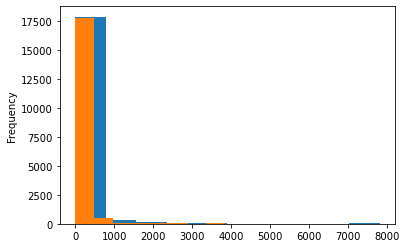

In [14]:
all_data_no_dupes["host_total_listings_count"].plot.hist()
all_data_no_dupes["host_listings_count"].plot.hist()

**host_listings_count and host_total_listings_count appear to be the same

In [15]:
# Drop one of the above variables in the chart
eda_subset = all_data_no_dupes.drop(
    columns = ["scrape_id", "listing_url", "picture_url", "host_id", "host_url", 
               "host_name", "host_since", "host_location", "host_about", 
               "host_response_time", "host_response_rate", "host_acceptance_rate", 
               "host_is_superhost", "host_thumbnail_url", "host_picture_url", 
               "host_verifications", "host_has_profile_pic", "host_identity_verified"
               ], 
    axis = 1
)

In [16]:
# Descriptive Statistics of a Select Subset of Features
eda_subset.describe().T

,count,mean,min,25%,50%,75%,max,std
id,18627.0,244970506009365984.0,6.0,29943733.0,49818439.0,628769716496820864.0,853653678315646848.0,333476445445734720.0
last_scraped,18627,2023-01-27 14:34:06.706393856,2022-06-15 00:00:00,2022-12-24 00:00:00,2023-03-25 00:00:00,2023-03-25 00:00:00,2023-03-25 00:00:00,NaN
host_listings_count,18576.0,84.257321,0.0,1.0,4.0,20.0,4807.0,374.064936
host_total_listings_count,18576.0,121.971307,0.0,2.0,5.0,29.0,7816.0,525.94779
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,18627.0,32.763184,32.51986,32.718332,32.75485,32.798349,33.12569,0.092287
longitude,18627.0,-117.172498,-117.28258,-117.246039,-117.16462,-117.129225,-116.89656,0.073437
accommodates,18627.0,4.815483,0.0,2.0,4.0,6.0,16.0,3.168323
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,17089.0,1.985195,1.0,1.0,2.0,3.0,34.0,1.289118


## Missing Values Evaluation

In [17]:
# Examine Which Features Have Missing Values
eda_subset.isnull().sum().to_frame(name = "Missing_Value_Count").query("Missing_Value_Count > 0")

,Missing_Value_Count
description,138
neighborhood_overview,6735
host_neighbourhood,2449
host_listings_count,51
host_total_listings_count,51
neighbourhood,6735
neighbourhood_group_cleansed,18627
bathrooms,18627
bathrooms_text,6
bedrooms,1538


In [18]:
# Look at columns with missing values for every record
eda_subset.isnull().sum().to_frame(name = "Missing_Value_Count").query("Missing_Value_Count == 18627")

,Missing_Value_Count
neighbourhood_group_cleansed,18627
bathrooms,18627
calendar_updated,18627


In [19]:
# Drop columns that cannot be filled
eda_subset = eda_subset.drop(
    columns = ["neighbourhood_group_cleansed", "calendar_updated"], axis = 1)

3 columns, _neighbourhood_group_cleansed_, _bathrooms_, and _calendar_updated_, are missing values for every single row. While, _neighbourhood_group_cleansed_ and _calendar_updated_ may be dropped, as their information is not especially key to determining price, the number of _bathrooms_ is key.

_bathrooms_text_ is a text version of the the numerical bathrooms column. _Bathrooms_text_ can be used to fill the missing values for _bathrooms_.

### Filling _bathrooms_ Missing Values with Values from _bathrooms_text_

In [20]:
# Sample of text data used to fill numerical field
eda_subset[["bathrooms", "bathrooms_text"]].head(5)

,bathrooms,bathrooms_text
8853,NaN,2 baths
8839,NaN,1.5 baths
8838,NaN,1 bath
8819,NaN,1 private bath
8823,NaN,1 private bath


In [21]:
# Function to extract integers and floats from text
def bath_number(text):
    try:
        num_baths = re.search("[\d.]", text).group()
        # Returns integer or float
        return num_baths
    except:
        # If no value could be returned
        # Return a missing value placeholder
        return np.nan

# Apply function to bathroom_text column to fill bathrooms column
eda_subset["bathrooms"] = eda_subset["bathrooms_text"].apply(
    lambda x: bath_number(x)
)


In [22]:
# Assess bathroom values that could not be filled
eda_subset[eda_subset["bathrooms"].isnull()]["bathrooms_text"].value_counts()
# Text descriptions that do not contain numerical text will have to be filled manually

bathrooms_text
Private half-bath    69
Half-bath            16
Shared half-bath      6
Name: count, dtype: int64

In [23]:
# Fill missing bathroom values based on text values
eda_subset.loc[eda_subset["bathrooms_text"] == "Private half-bath", ["bathrooms"]] = 0.5
eda_subset.loc[eda_subset["bathrooms_text"] == "Half-bath", ["bathrooms"]] = 0.5
eda_subset.loc[eda_subset["bathrooms_text"] == "Shared half-bath", ["bathrooms"]] = 0.5

In [24]:
# After imputing the bathroom values with _bathroom_text_,
# Only 6 missing values for bathrooms remain
eda_subset["bathrooms"].isnull().sum()

6

The feature bathrooms_text can now be dropped, as the feature bathroom now contains the same information, in numerical format.

In [25]:
# Drop bathrooms_text feature
eda_subset = eda_subset.drop(columns = ["bathrooms_text"], axis = 1)

## Zip Code and Median Income Feature Creation
From the given longitude and latitude coordinates, find the zip code of the rental property. Then, add a new column _median_income_ for the median income of the zip code, using census data.

**I think we might want to move this section to Preprocessing/Feature Enginnering - but I'm not sure because we also need it for EDA**

In [26]:
# Set up a search engine
search = SearchEngine()

# Function to search for a zip code based on a coordinate pair
def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    return result[0].zipcode

# Create a new column _zipcode_ and apply the get_zipcode function
## This takes a few minutes to complete
eda_subset['zipcode'] = eda_subset.apply(lambda x: get_zipcode(x["latitude"], x["longitude"]), axis=1)

Zipcode 92133 was unfound in the census data; the closest zip code geographically is 92101. All records with a zipcode of 92133 will be updated to 92101.

In [27]:
# Replacing zipcode 92133 with 92101
eda_subset.loc[eda_subset["zipcode"] == "92133", "zipcode"] = "92101"

### Median Income Data Information
Import in median income data and join the tables together based on zipcode.

In [28]:
# Read in median income information
income_df = pd.read_csv("../Data/SanDiego5Y2021_IncomeData.csv")

In [29]:
# Extract only the necessary columns
income_df_subset = income_df.filter(
    regex = "!!Households!!Estimate",
    axis = 1
)

# Rename Columns to just contain 5-digit zipcodes
income_df_subset.columns = [x[6:11] for x in income_df_subset.columns]

# Insert Label (Grouping) Col
income_df_subset.insert(0, "Labels", income_df["Label (Grouping)"])
# Set Label column as index
income_df_subset.set_index("Labels", inplace = True)

# Transpose Table
income_df_subset_T = income_df_subset.T
# Move zipcodes out of index - make a column of zipcodes
income_df_subset_T.reset_index(inplace = True)
# Rename index column as "zipcode"
income_df_subset_T.columns.values[0] = "zipcode"
# Keep just median income column
median_income_df = income_df_subset_T[["zipcode", "Median income (dollars)"]]

median_income_df.head(3)

Labels,zipcode,Median income (dollars)
0,91902,"112,331"
1,91910,"77,005"
2,91911,"70,873"


In [30]:
# Add to eda_subset _median_income_ column based on existing zipcode
eda_income_df = pd.merge(eda_subset, median_income_df, how = "inner", on = "zipcode")

# Rename median income column
eda_income_df.rename(
    columns = {"Median income (dollars)" : "median_income_dollars"}, 
    inplace=True
)
# eda_income_df.columns.values[-1] = "median_income_dollars"

# Change median income datatype from string to float
eda_income_df["median_income_dollars"] = eda_income_df[
    "median_income_dollars"].str.replace(',', '').astype(float)

## Altering Datatypes for EDA Purposes

In [31]:
# Drop unnecessary symbols in price
eda_income_df['price'] = eda_income_df['price'].str.replace('$', '')
eda_income_df['price'] = eda_income_df['price'].str.replace(',', '')
# Convert price to a numeric feature
eda_income_df['price'] = pd.to_numeric(eda_income_df['price'])

# Change zip code to a numeric feature for plottting purposes
eda_income_df['zipcode'] = pd.to_numeric(eda_income_df['zipcode'])

## Feature Distribution
Examine the distribution of each feature

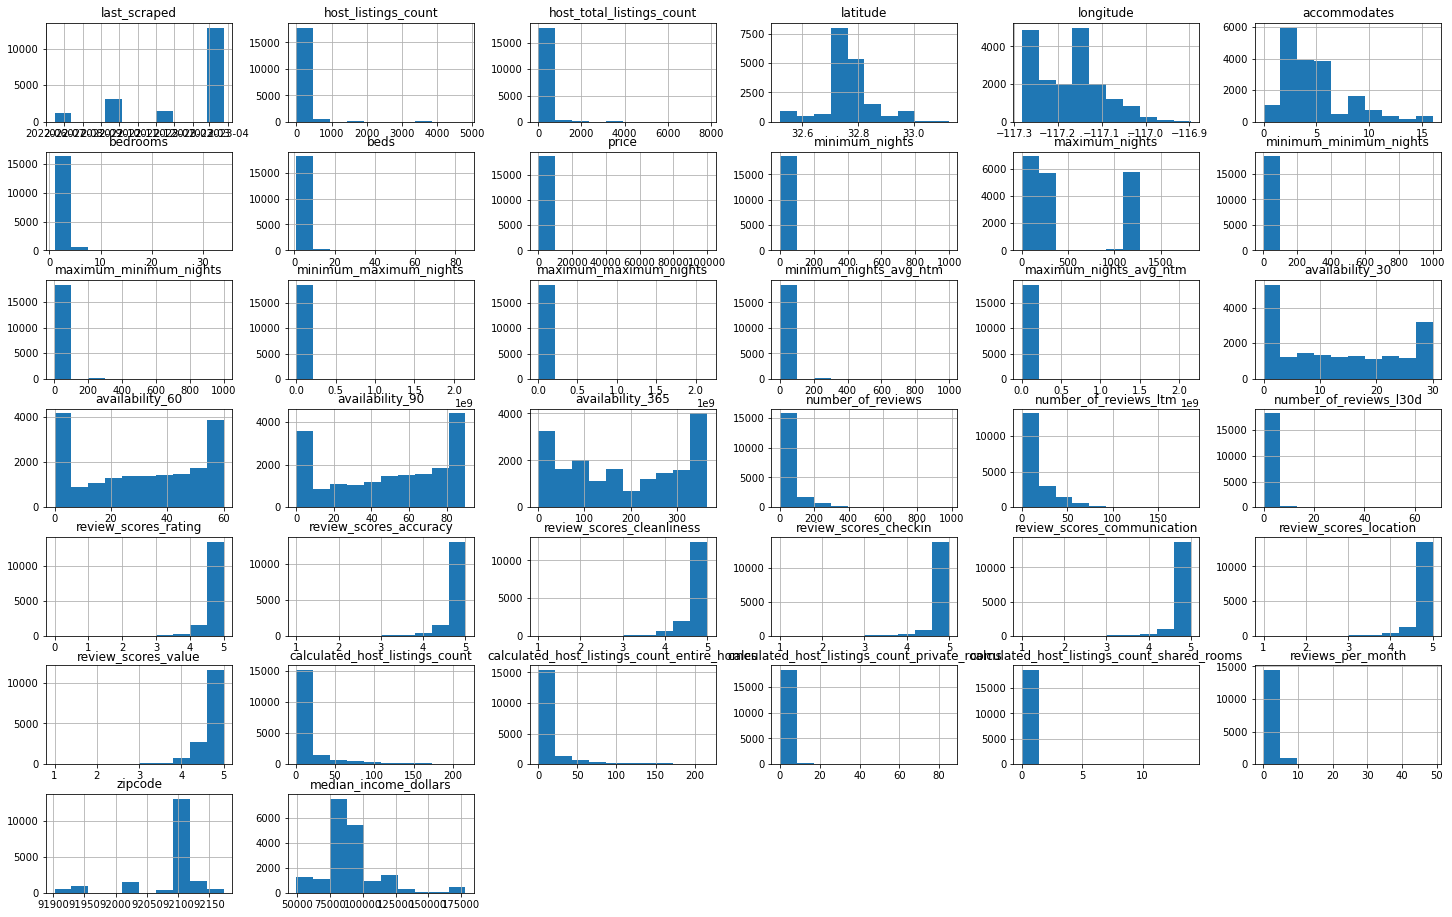

In [32]:
# Set figure dimensions
fig = plt.figure(figsize=(25, 16))
axes = fig.gca()

# Plot a histogram for each feature
# Drop arbitrary id column prior to plotting
eda_income_df.drop(columns = "id", axis = 1).hist(ax = axes)

plt.show()

## Bivariate EDA

### Relationship of Numerical Predictors to Outcome Variable (Price)

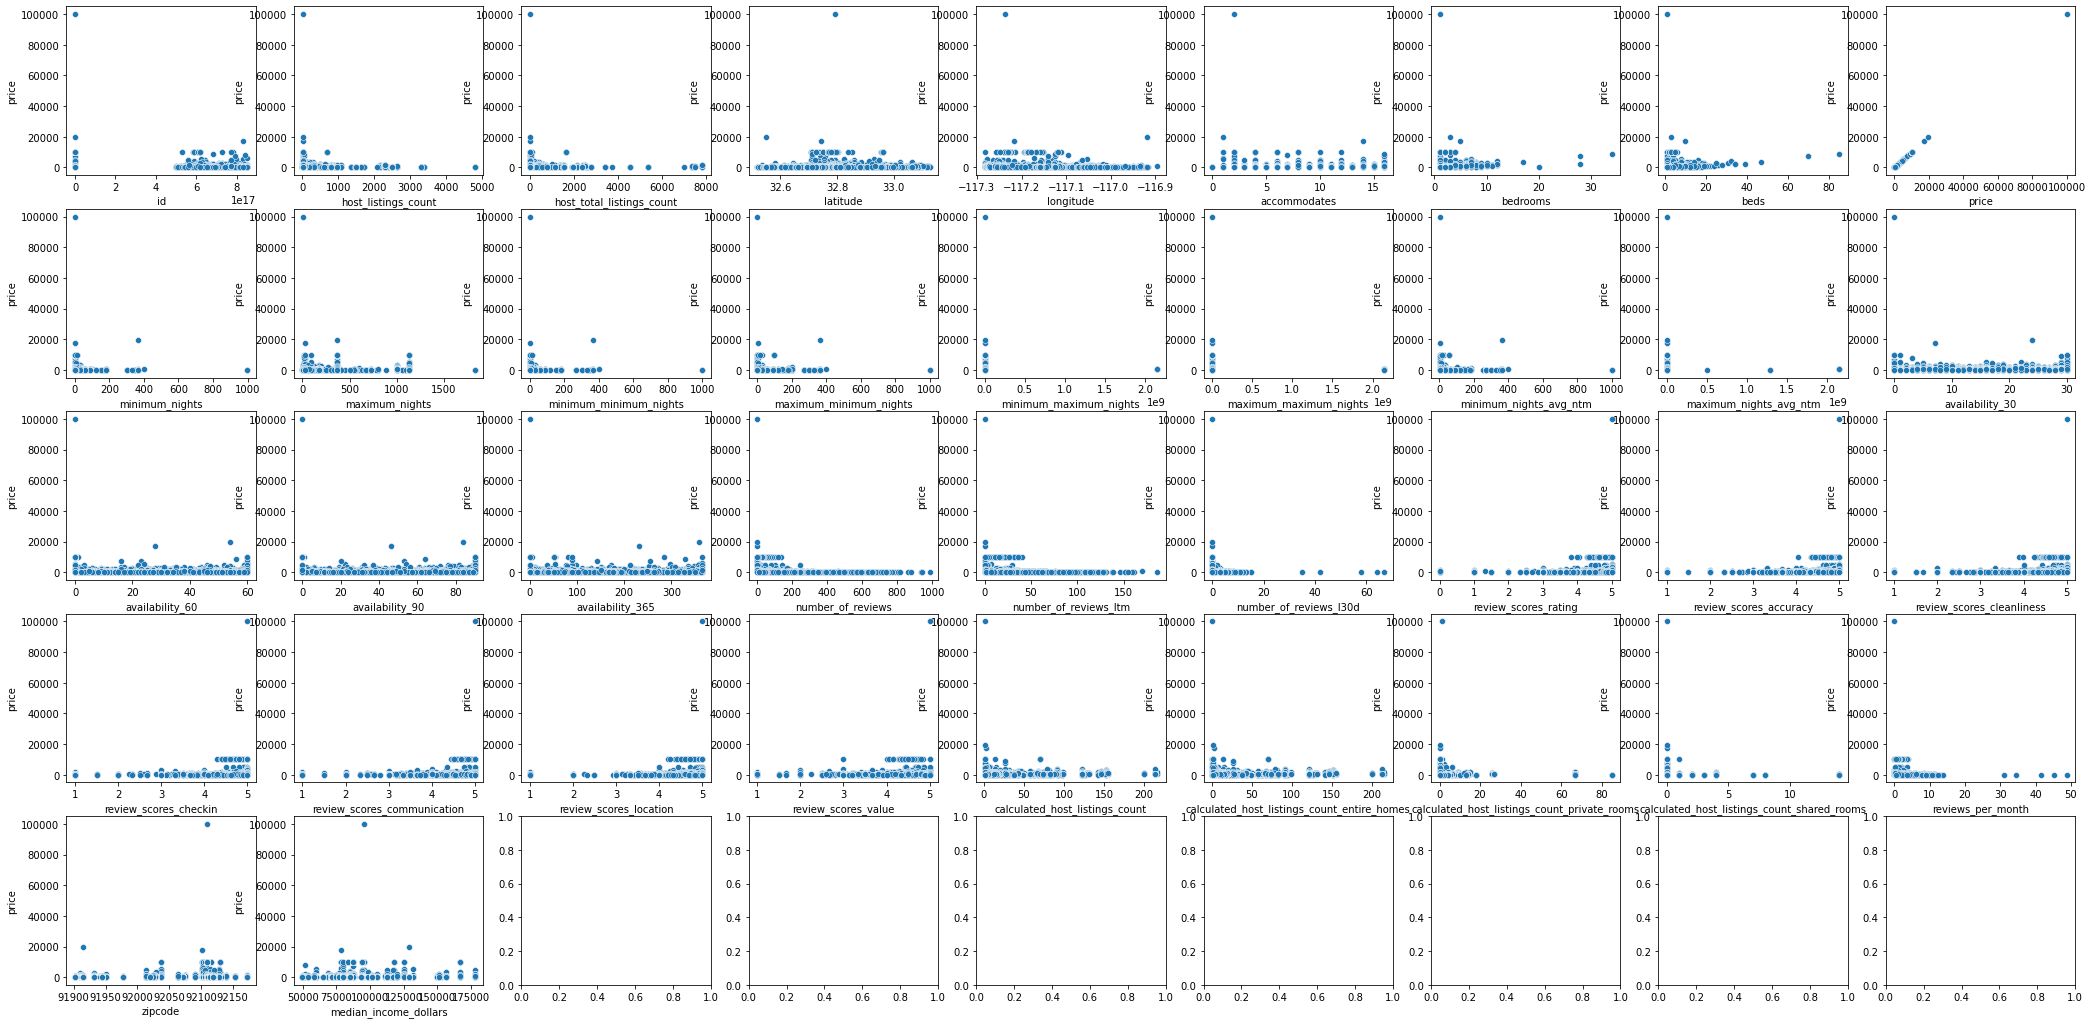

In [33]:
# Subset numerical columns
num_feat_df = eda_income_df.select_dtypes(["int", "float"])

# Set up enough boxes for 38 features
fig, axes = plt.subplots(nrows = 5, ncols = 9)
fig.set_figheight(18)
fig.set_figwidth(36)

# Iterate over numerical features to plot against price
i = 0
j = 0
for col in num_feat_df.columns.values.tolist():
    sns.scatterplot(x = num_feat_df[col], y = num_feat_df["price"], 
                    ax = axes[i,j])
    # fill the subplots row by row
    if j < 8:
        j += 1
    # if j = 9, move to the next row
    else:
        i += 1
        j =0

plt.show();

## Feature Correlation
Evaluate the correlation amongst variables via Pearson's correlation coefficient and a heatmap.

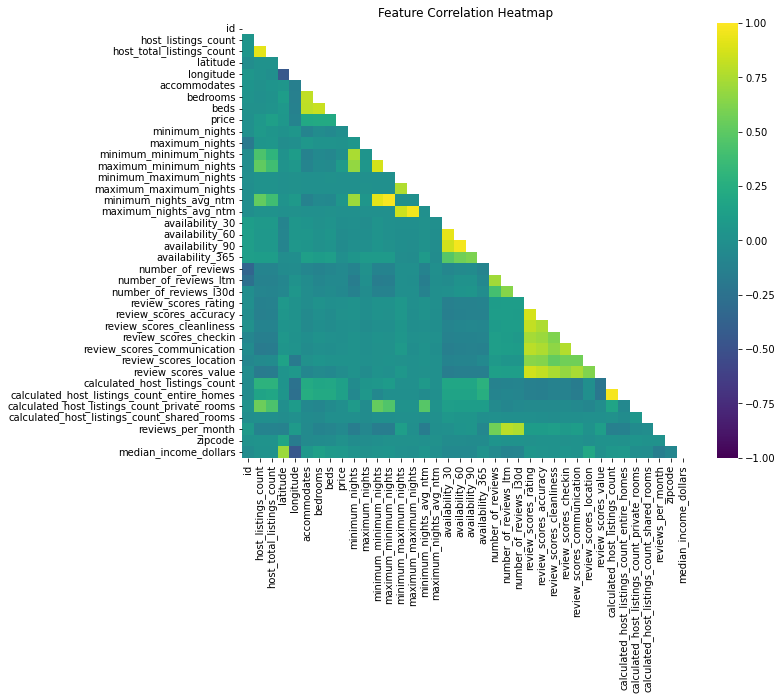

In [34]:
# Calculate the correlation coefficient between every feature pair
corr_matrix = eda_income_df.select_dtypes(["int", "float"]).corr()
# Create a mask 
matrix_mask = np.triu(np.ones_like(corr_matrix))

# Convert the correlation matrix into a heatmap
# Set values to range from -1 to 1
plt.figure(figsize=(10, 8))
corr_heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1,
                           cmap = "viridis",
                           mask = matrix_mask)

corr_heatmap.set_title("Feature Correlation Heatmap")
plt.show();

In [35]:
# Function to observe highly correlated features
def high_correlation(df, threshold = 0.75):
	# Correlation Matrix for Numerical Features
	corr_matrix = df.select_dtypes(["int", "float"]).corr()

	# Get features with a correlation coefficient above the set threshold
	# Use the absolute value to capture both positive and negative coefficients
	corr_features = np.where(np.abs(corr_matrix) > threshold)

	# Exclude self-correlation (i.e. feat. a is correlated with feat. a)
	corr_features = [
		(corr_matrix.iloc[x,y], x, y) for x, y in zip(*corr_features) if x != y and x < y]
	
	# Sort Values
	corr_list = sorted(corr_features, key = lambda x: -abs(x[0]))

	if corr_list == []:
		print("There are no highly correlated features with correlation above", threshold)
	else:
		for z, x, y in corr_list:
			cols = df.select_dtypes(["int", "float"]).columns
			print ("%s and %s = %.3f" % (corr_matrix.index[x], corr_matrix.columns[y], z))

In [36]:
high_correlation(eda_income_df)

maximum_minimum_nights and minimum_nights_avg_ntm = 0.980
calculated_host_listings_count and calculated_host_listings_count_entire_homes = 0.972
availability_60 and availability_90 = 0.968
maximum_maximum_nights and maximum_nights_avg_ntm = 0.963
availability_30 and availability_60 = 0.926
minimum_minimum_nights and minimum_nights_avg_ntm = 0.917
host_listings_count and host_total_listings_count = 0.914
review_scores_rating and review_scores_accuracy = 0.871
minimum_minimum_nights and maximum_minimum_nights = 0.870
review_scores_rating and review_scores_value = 0.857
availability_30 and availability_90 = 0.856
minimum_maximum_nights and maximum_nights_avg_ntm = 0.847
bedrooms and beds = 0.830
review_scores_accuracy and review_scores_value = 0.816
review_scores_rating and review_scores_cleanliness = 0.815
accommodates and bedrooms = 0.812
accommodates and beds = 0.802
review_scores_rating and review_scores_communication = 0.796
number_of_reviews_ltm and reviews_per_month = 0.796
review_

## Feature Variance
Assess the variance of all features and determine if features with a near-zero variance should be kept or removed.

In [37]:
var_df = eda_income_df.select_dtypes(include=np.number).var()
var_df.sort_values().head(25)

longitude                                         0.005393
latitude                                          0.008517
review_scores_location                            0.104557
review_scores_checkin                             0.120985
review_scores_communication                       0.132739
review_scores_accuracy                            0.144201
review_scores_cleanliness                         0.153217
review_scores_value                               0.165201
review_scores_rating                              0.186128
calculated_host_listings_count_shared_rooms       0.432101
bedrooms                                          1.661824
reviews_per_month                                 3.529879
number_of_reviews_l30d                            3.677599
beds                                              5.160855
accommodates                                     10.038270
calculated_host_listings_count_private_rooms     52.657084
availability_30                                 118.2880

## Maps
### Plot zip codes and boundaries colored by median income

Source for San Diego geojson file - https://sdgis-sandag.opendata.arcgis.com/datasets/SANDAG::zip-code/explore?location=32.916477%2C-114.604036%2C8.00

In [38]:
# Change median income column to a float data type for chloropleth
median_income_df["Median income (dollars)"] = median_income_df[
    "Median income (dollars)"].str.replace(',', '').astype(float)

# Read in geojson file
SD_zip_shapes = geopandas.read_file("../Data/SDZips.geojson")

# Join the zipcodes we need
median_income_df["zipcode"] = pd.to_numeric(median_income_df["zipcode"])
SD_gdf = median_income_df.merge(
    SD_zip_shapes, left_on = "zipcode", 
    right_on = "ZIP", how = "left"
)

# Had a few duplicate zipcodes from the geojson, we'll drop them
SD_gdf = SD_gdf.drop_duplicates(subset = ["zipcode"])

# Finish geodataframe
SD_gdf_income = geopandas.GeoDataFrame(
    SD_gdf["Median income (dollars)"], 
    geometry=SD_gdf.geometry
    )

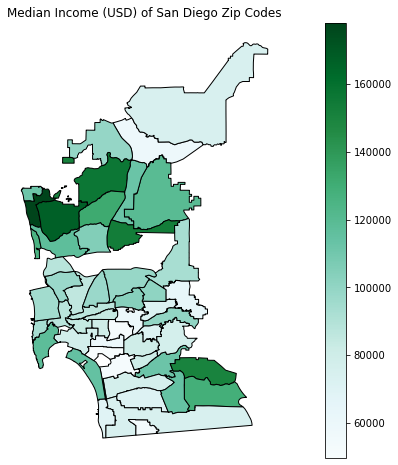

In [39]:
# Plot our map
SD_gdf_income.plot(
    column = "Median income (dollars)", 
    cmap = "BuGn", edgecolor = "k", 
    legend = True, figsize = (16,8)
)
plt.title("Median Income (USD) of San Diego Zip Codes")
plt.axis("off");

### Average Rent by Zip Code

In [40]:
# Create an average rent-zipcode dataframe
rent_zip = eda_income_df.groupby(by = 'zipcode', as_index = False)['price'].mean()
rent_zip = rent_zip.merge(SD_gdf, left_on = 'zipcode', right_on = 'zipcode')
rent_zip_gdf = geopandas.GeoDataFrame(rent_zip['price'], geometry = rent_zip['geometry'])

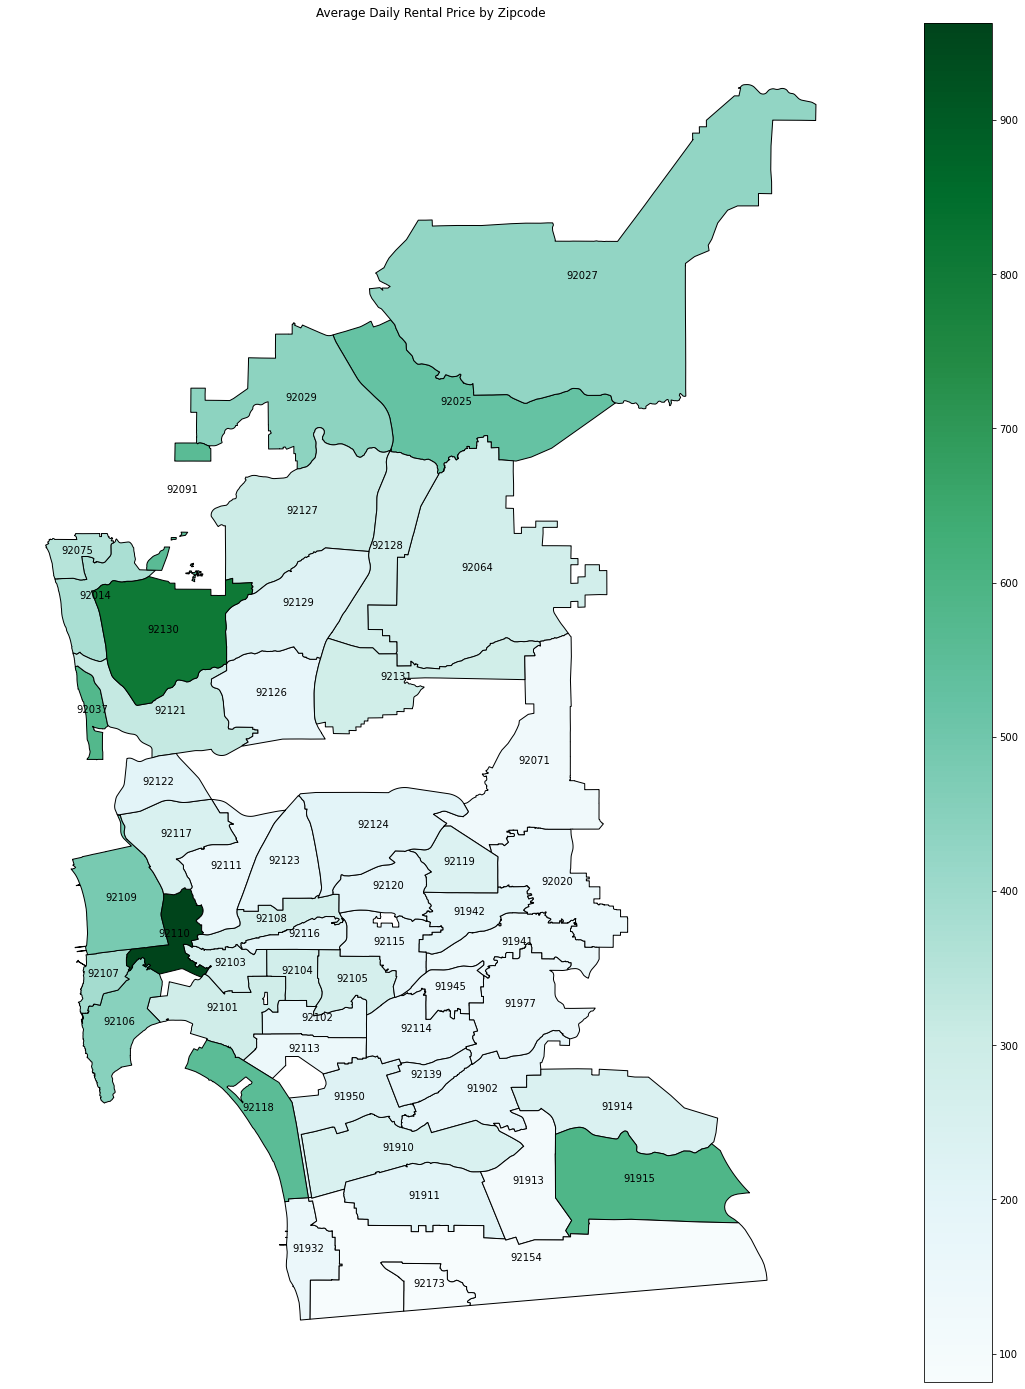

In [41]:
# Plot average rent by zip code
rent_map = rent_zip_gdf.plot(
    column = "price", cmap = "BuGn", 
    edgecolor = "k", legend = True, 
    figsize=(25,25)
)

# Label areas with zipcode
rent_zip.apply(lambda x: rent_map.annotate(
    text = x["zipcode"], 
    xy = x.geometry.centroid.coords[0], 
    ha = "center"), axis=1)

plt.title("Average Daily Rental Price by Zipcode")
plt.axis('off');

## EDA by Property Type

### Create new binary column for Property Type 

- New binary column (property_type_binary) - Values are either room or house
- New binary column private (0 - not a private room (i.e. shared room), 1 - private)

In [42]:
#Create the new "property_type_binary" column
eda_income_df["property_type_binary"] = eda_income_df["property_type"].apply(
    lambda x: "room" if "room" in x.lower() else "house")

# Create the new "private" column
eda_income_df["private"] = eda_income_df["property_type"].apply(
    lambda x: 1 if "private" in x.lower() or "entire" in x.lower() else 0)

# Optional: You can convert the "private" column to integer type if needed
eda_income_df["private"] = eda_income_df["private"].astype(int)

# Print the updated DataFrame
eda_income_df[["property_type", "property_type_binary", "private"]]

,property_type,property_type_binary,private
0,Entire home,house,1
1,Private room in condo,room,1
2,Entire home,house,1
3,Entire home,house,1
4,Camper/RV,house,0
...,...,...,...
18622,Entire rental unit,house,1
18623,Entire home,house,1
18624,Private room in home,room,1
18625,Entire guesthouse,house,1


### Some Counting Stats
Private vs. non-private - The majority of properties are private, with a very small proportion being non-private.

In [43]:
eda_income_df["private"].value_counts()

private
1    17909
0      718
Name: count, dtype: int64

House vs. Room
We have a lot more houses than rooms. Not suprisingly houses also cost around 170 more than rooms on average.

In [44]:
eda_income_df["property_type_binary"].value_counts()

property_type_binary
house    15300
room      3327
Name: count, dtype: int64

In [45]:
# Calculate average price for whole house-type and single room-type properties
eda_income_df.groupby(by='property_type_binary', as_index=False)['price'].mean()

,property_type_binary,price
0,house,370.024641
1,room,198.301773


### House vs. Rooms by Zip Code
Do any areas have more houses than rooms or vice-versa

In [46]:
# Construct a dataframe - number of house and room type properties by zipcode
house_room = pd.crosstab(eda_income_df.zipcode, eda_income_df.property_type_binary)
# Convert counts to a ratio/proportion
house_room['ratio'] = house_room['house']/house_room['room']

house_room = house_room.merge(SD_gdf, left_on='zipcode', right_on='zipcode')
house_room_gdf = geopandas.GeoDataFrame(house_room['ratio'], geometry=house_room['geometry'])

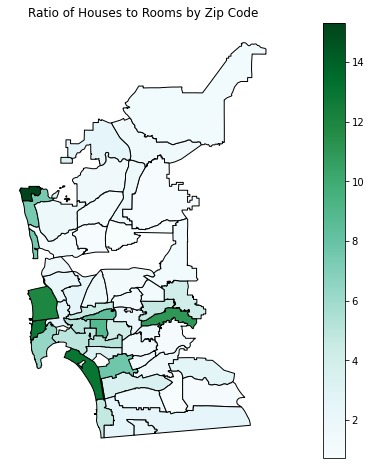

In [47]:
# Plot our map
house_room_gdf.plot(column="ratio", cmap = 'BuGn', edgecolor = 'k', legend = True, figsize=(16,8))
plt.title("Ratio of Houses to Rooms by Zip Code")
plt.axis('off');

In the above map, a darker shaded area indicates a higher proportion of house-type properties over room-type properties, whereas ligher shaded areas indiciate the opposite.

## Export Results

In [48]:
#eda_income_df.to_csv("../Data/eda.csv.gz", compression = "gzip", index = False)